## Fina Short UEP239 Final Project
#### Suitability Analysis: Where Boston-based college grads (like me) should live

In this project I will execute a suitability analysis determining the most suitable ZIP Code Tabulation Area (ZCTA) for recent Boston-area college grads like me to keep an eye on while seeking housing. The project focuses on the Boston Metropolitan Area, as defined by the boundary of the Boston Region Metropolitan Planning Organization (MPO). The analysis uses the following  indicators to calculate and map suitability for this demographic:

**Points of Interest: transit access** 
- Areas with more 1) MBTA bus stops and 2) MBTA T stations will help us get around in a cost-effective way

**Feeding ourselves: fresh food access**
- Prevalence of farmer's markets: important for an environmentally-conscious generation that tries to eat local when we can

**Demographics of Interest: Age, Housing Price and Pop. Density**
- Mean housing price/rent payment, where lowest rent means most suitable
- Age distribution of neighborhood population, ranked by percent of population that is in their 20s
- Population density, where densest = best (the more the merrier!)

## Analysis overview

**Below is a rough outline of the analysis I will perform:**
1. **Pinpoint area of focus** > Read in > visualize > and join Massachusetts base map data to pinpoint our field of analysis
2. **Measure train access** > join MBTA nodes file to Boston Zip Codes data > normalize to index on 0-1 scale where 1= high suitability with most T stations per zip code
3. **Measure bus access** > join MBTA bus stops file to Boston Zip Codes data > normalize to index on 0-1 scale where 1= high suitability with most bus stops per zip code
4. **Assess median housing price** > join census data to Boston Zip Codes data to calculate housing by zip > normalize to index on 0-1 scale where 1= high suitability with lowest rent
5. **Calculate population age distribution** > use ACS population data to determine age averages by region > reclassify > (closest to = high risk) (25 pts)
6. **Calculate weighted and unweighted suitability map** > using an additive scale derived from all indexed indicators

**How will we quantify a suitable "zip code tabulation area?" Using the following data:**
- MassGIS (Bureau of Geographic Information) | For MBTA station data, state outline data & farmer's market data
- Massachusetts Department of Transportation | For bus stop data
- U.S. Census Bureau, 2015-2019 American Community Survey 5-Year Estimates | For age, population & housing price data 

## Import Dependencies

In [346]:
import rasterio
from rasterio.plot import show
from rasterio import features

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment=None
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

import richdem as rd
from scipy import ndimage
from rasterstats import zonal_stats
from shapely.geometry import box

## Massachusetts & Boston Area Datasets

Now that we have the dependency imports we need, we can read in the data delineating our regions of analysis. First, we will use a state outline containing a detailed coastline to clip our zip codes file, thus providing a more accurate outline for zip code data that will match better with the Boston Region boundary.

<AxesSubplot:>

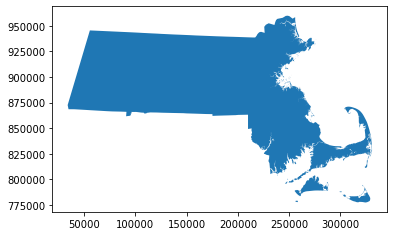

In [470]:
#importing a MA outline with detailed coastline & visualizing it to ensure it was read in correctly
outline25k= gpd.read_file("project_data\\OUTLINE25K_POLY\\OUTLINE25K_POLY.shp")
outline25k.plot()

<AxesSubplot:>

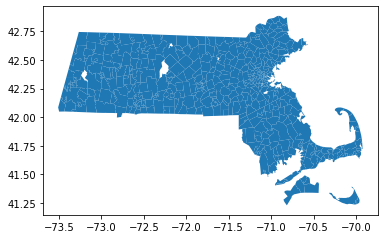

In [471]:
#Next, import ZCTA data & extract all the ZCTAs whose centroid is within the Boston Region MPO boundary.
zcta= gpd.read_file("project_data\\tl_2010_25_zcta510\\tl_2010_25_zcta510.shp")
zcta.plot()

In [289]:
zcta.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands.  British Virgin Island

The ZCTA shapefile is projected in the 2D CRS of EPSG:4269. We will reproject to EPSG:6491, the newest standard recommended for mainland Massachusetts.

In [291]:
#Now we prep to clip the ZCTAs shapefile into the more detailed outline.
#The layers must have the same CRS to be clipped so we will transform both to PSG:6491, NAD83 (2011) / Massachusetts Mainland 
zcta_proj = zcta.to_crs("EPSG:6491")
outline25k_proj = outline25k.to_crs("EPSG:6491")
#check to ensure the same CRS now
zcta_proj.crs == outline25k_proj.crs

True

In [275]:
#clip ZCTA into more detailed outline and look at output table
zctas_clipped = gpd.clip(zcta_proj, outline25k_proj)
zctas_clipped

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry
0,25,02536,2502536,B5,G6350,S,71696166,9066635,+41.5969756,-070.5678768,N,"MULTIPOLYGON (((275688.314 812598.785, 275674...."
1,25,02556,2502556,B5,G6350,S,10034104,1164445,+41.6394454,-070.6245149,N,"MULTIPOLYGON (((272816.173 818906.998, 272692...."
2,25,02540,2502540,B5,G6350,S,27746696,4550024,+41.5741900,-070.6282848,N,"MULTIPOLYGON (((273126.263 818856.200, 273125...."
3,25,02646,2502646,B5,G6350,S,7798581,801405,+41.6705961,-070.0714493,N,"MULTIPOLYGON (((318348.040 826281.410, 318355...."
4,25,01237,2501237,B5,G6350,S,160121626,1140685,+42.5478177,-073.2680327,N,"POLYGON ((57310.861 917322.668, 57280.413 9173..."
...,...,...,...,...,...,...,...,...,...,...,...,...
533,25,01537,2501537,B5,G6350,S,18085937,295745,+42.1589660,-071.8970514,N,"POLYGON ((167131.394 882124.787, 167132.834 88..."
534,25,01503,2501503,B5,G6350,S,33598202,523984,+42.3849290,-071.6338895,N,"POLYGON ((192620.359 903410.285, 192571.893 90..."
535,25,01452,2501452,B5,G6350,S,106373488,2406515,+42.4895983,-072.0028783,N,"POLYGON ((155270.303 910753.057, 155048.771 91..."
536,25,01571,2501571,B5,G6350,S,53915863,2717076,+42.0537777,-071.9350751,N,"POLYGON ((162378.916 864062.624, 162368.069 86..."


Next is a shapefile with polygon data for the Boston Metropolitan Area as defined by the boundary of the Boston Region Metropolitan Planning Organization (MPO).

In [314]:
mpo= gpd.read_file("\\Users\\finas\\Documents\\my work\\School work\\Tufts GRAD\\Spring 2021\\UEP239\\uep239-final-project\\project_data\\MPO_Boundaries\\MPO_Boundaries.shp")
#first things first check coordinate system
mpo.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [315]:
#change to PSG:6491, NAD83 (2011) / Massachusetts Mainland to match others
mpo = mpo.to_crs("EPSG:6491")
mpo.crs

<Projected CRS: EPSG:6491>
Name: NAD83(2011) / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [316]:
#extract boston region from MPO, using centroid within 
zcta_boston = zcta_proj[zcta_proj.centroid.within(mpo['geometry'][10])]

<AxesSubplot:>

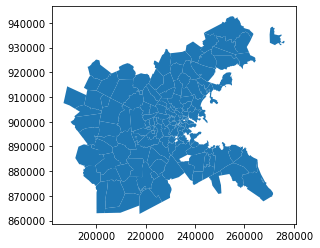

In [317]:
#visualizing plot to make sure importing worked
zcta_boston.plot()

## Data for Availability & Accessibility | Transit Access
#### To map transit access, we'll index density of MBTA bus and subway stops per zip code. Let's start with the buses.

<AxesSubplot:>

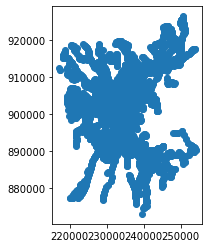

In [468]:
#read in bus stops file
buspoints= gpd.read_file("project_data\\MBTA_Bus_Stops\\MBTA_Bus_Stops.shp")
buspoints.plot()

In [319]:
#set projected crs for this points layer
buspoints = buspoints.to_crs("EPSG:6491")
buspoints.crs

<Projected CRS: EPSG:6491>
Name: NAD83(2011) / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

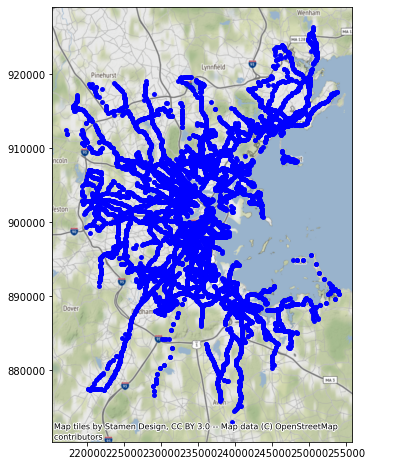

In [296]:
#plotting bus points within Boston zip codes
import contextily as cx
fig, ax = plt.subplots(figsize=(10,8))

#need to add title and make map size larger
buspoints.plot(ax=ax, color='blue', markersize=15);

#zcta_boston.plot(ax=ax, facecolor='gray');

cx.add_basemap(ax, crs=buspoints.crs.to_string()) #crs to string outputs coordinates of tpoints dataset

In [320]:
#Join to facilitate summarizing indicator values of T points for each ZCTA in the study area
joined_bus = gpd.sjoin(buspoints, zcta_boston, how='left', op='intersects') 
joined_bus

,OBJECTID,STOP_ID,STOP_NAME,TOWN,TOWN_ID,geometry,index_right,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10
0,1,3077,Gallivan Blvd @ opp Marsh St,BOSTON,35,POINT (237120.669 892643.408),316.0,25,02124,2502124,B5,G6350,S,7777026.0,186127.0,+42.2858047,-071.0705705,N
1,2,841,Lagrange St @ Virgil Rd,BOSTON,35,POINT (227915.195 892644.017),317.0,25,02132,2502132,B5,G6350,S,11813317.0,248109.0,+42.2804549,-071.1620165,N
2,3,446,Norfolk St @ Nelson St,BOSTON,35,POINT (234385.661 892644.944),316.0,25,02124,2502124,B5,G6350,S,7777026.0,186127.0,+42.2858047,-071.0705705,N
3,4,847,Lagrange St opp Virgil St,BOSTON,35,POINT (227912.601 892650.156),317.0,25,02132,2502132,B5,G6350,S,11813317.0,248109.0,+42.2804549,-071.1620165,N
4,5,3079,Adams St @ Minot St,BOSTON,35,POINT (236644.812 892651.990),316.0,25,02124,2502124,B5,G6350,S,7777026.0,186127.0,+42.2858047,-071.0705705,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7805,7806,9097,Grove St @ Lebanon St,MELROSE,178,POINT (236229.381 911541.866),167.0,25,02176,2502176,B5,G6350,S,12117823.0,219781.0,+42.4557230,-071.0590194,N
7806,7807,5911,Grove St @ Lebanon St,MELROSE,178,POINT (236236.036 911542.538),167.0,25,02176,2502176,B5,G6350,S,12117823.0,219781.0,+42.4557230,-071.0590194,N
7807,7808,5975,Wyoming Ave opp Cleveland St,MELROSE,178,POINT (234977.387 911544.999),167.0,25,02176,2502176,B5,G6350,S,12117823.0,219781.0,+42.4557230,-071.0590194,N
7808,7809,15976,Wyoming Ave @ Cleveland St,MELROSE,178,POINT (234971.098 911547.184),167.0,25,02176,2502176,B5,G6350,S,12117823.0,219781.0,+42.4557230,-071.0590194,N


In [321]:
print('Our data now contains', joined_bus['STOP_ID'].nunique(), 'stations. So where should you live for easy bus access?')

Our data now contains 7810 stations. So where should you live for easy bus access?


In [322]:
#Group by number of stations per zip code
bus_perzip = joined_bus.groupby('ZCTA5CE10')[['STOP_ID']].nunique().reset_index() #double square brackets for df
#do i need to rename
bus_perzip.rename(columns={'STOP_ID':'stop_count'},inplace=True)
#need to join back to zip codes df
zcta_boston = zcta_boston.merge(bus_perzip, how='left', on='ZCTA5CE10')
#replace NaNs with 0
zcta_boston['stop_count'] = zcta_boston['stop_count'].fillna(0)
#take a look at new df to be used for visuals
zcta_boston

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry,stop_count
0,25,01905,2501905,B5,G6350,S,9219345,1195154,+42.4659985,-070.9757922,N,"POLYGON ((243830.175 913871.662, 243877.753 91...",122.0
1,25,01904,2501904,B5,G6350,S,11708211,1303900,+42.4924563,-070.9739297,N,"POLYGON ((245713.029 914796.777, 245700.484 91...",132.0
2,25,01915,2501915,B5,G6350,S,39091336,3958118,+42.5702688,-070.8669962,N,"POLYGON ((250741.171 926889.812, 250787.714 92...",80.0
3,25,02462,2502462,B5,G6350,S,1369318,69749,+42.3287076,-071.2559002,N,"MULTIPOLYGON (((222090.890 897305.465, 222058....",0.0
4,25,01760,2501760,B5,G6350,S,38359306,2599042,+42.2848223,-071.3488109,N,"POLYGON ((208151.539 893024.178, 208131.535 89...",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,25,02071,2502071,B5,G6350,S,2513156,33452,+42.1034247,-071.2735885,N,"MULTIPOLYGON (((217320.943 872620.799, 217310....",0.0
157,25,02343,2502343,B5,G6350,S,18146751,280250,+42.1489129,-071.0037371,N,"POLYGON ((243087.621 878272.261, 243078.760 87...",56.0
158,25,02129,2502129,B5,G6350,S,3492181,1266666,+42.3796570,-071.0614875,N,"POLYGON ((235383.264 902518.035, 235381.204 90...",64.0
159,25,02128,2502128,B5,G6350,S,12561059,2952872,+42.3611289,-071.0069754,N,"POLYGON ((237939.099 904138.351, 237949.737 90...",104.0


Of course, some zip codes are much larger than others, so prevalence of bus stops might not necessarily mean you're more likely to have good access. Let's use our new stop counts to calculate bus stop density as a better indicator of transit access.

In [325]:
zcta_boston['bus_density'] = zcta_boston['stop_count']/zcta_boston['ALAND10']
zcta_boston

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry,stop_count,bus_density
0,25,01905,2501905,B5,G6350,S,9219345,1195154,+42.4659985,-070.9757922,N,"POLYGON ((243830.175 913871.662, 243877.753 91...",122.0,0.000013
1,25,01904,2501904,B5,G6350,S,11708211,1303900,+42.4924563,-070.9739297,N,"POLYGON ((245713.029 914796.777, 245700.484 91...",132.0,0.000011
2,25,01915,2501915,B5,G6350,S,39091336,3958118,+42.5702688,-070.8669962,N,"POLYGON ((250741.171 926889.812, 250787.714 92...",80.0,0.000002
3,25,02462,2502462,B5,G6350,S,1369318,69749,+42.3287076,-071.2559002,N,"MULTIPOLYGON (((222090.890 897305.465, 222058....",0.0,0.000000
4,25,01760,2501760,B5,G6350,S,38359306,2599042,+42.2848223,-071.3488109,N,"POLYGON ((208151.539 893024.178, 208131.535 89...",0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,25,02071,2502071,B5,G6350,S,2513156,33452,+42.1034247,-071.2735885,N,"MULTIPOLYGON (((217320.943 872620.799, 217310....",0.0,0.000000
157,25,02343,2502343,B5,G6350,S,18146751,280250,+42.1489129,-071.0037371,N,"POLYGON ((243087.621 878272.261, 243078.760 87...",56.0,0.000003
158,25,02129,2502129,B5,G6350,S,3492181,1266666,+42.3796570,-071.0614875,N,"POLYGON ((235383.264 902518.035, 235381.204 90...",64.0,0.000018
159,25,02128,2502128,B5,G6350,S,12561059,2952872,+42.3611289,-071.0069754,N,"POLYGON ((237939.099 904138.351, 237949.737 90...",104.0,0.000008


Visualizing bus stop density by zip code:

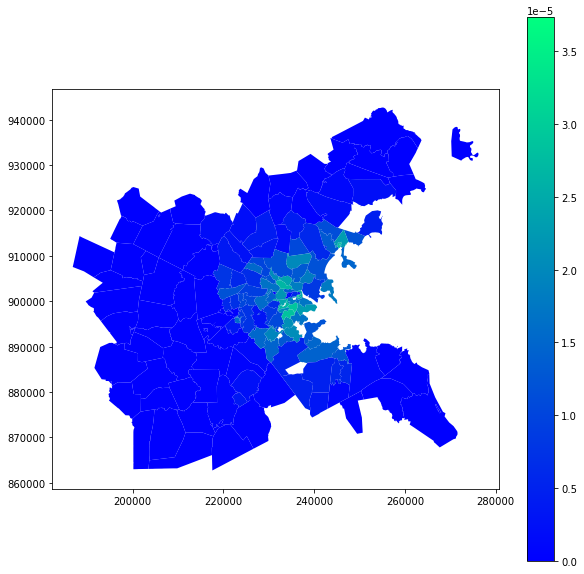

In [326]:
zcta_boston.plot(column='bus_density',
           alpha=1,
           #ax=base,
           legend=True,
           cmap='winter',
           figsize=(10, 10))
plt.show()

It looks like buses are much more densely packed within many of the smaller zip codes concentrated at the center of Boston. Out of curiosity, let's look at the number of buses by zip code without accounting for area.

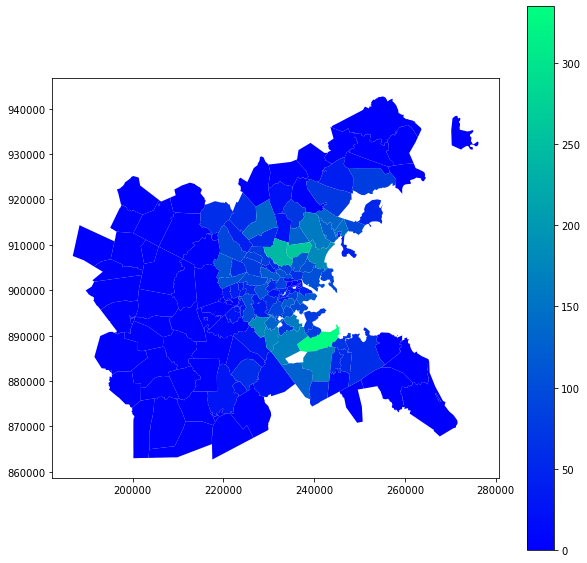

In [328]:
zcta_boston.plot(column='stop_count',
           alpha=1,
           #ax=base,
           legend=True,
           cmap='winter',
           figsize=(10, 10))
plt.show()

Hmm, there are indeed some areas that looked like they had better access than they truly do- good thing we accounted for area. Now let's look at which zip codes have the best access based on our new density indicator. In the table below, the top 5 rows represent the areas with the best bus access, while the bottom 5 show those with the worst according to our density calculations.

In [333]:
zcta_sorted = zcta_boston.sort_values(by=['bus_density'], ascending=False)
zcta_sorted

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry,stop_count,bus_density,bus_norm
143,25,02203,2502203,B5,G6350,S,80317,0,+42.3605978,-071.0587753,N,"POLYGON ((236473.358 901026.717, 236428.275 90...",3.0,0.000037,1.000000
15,25,02118,2502118,B5,G6350,S,2850698,15328,+42.3378600,-071.0698052,N,"POLYGON ((234492.912 898353.960, 234474.534 89...",83.0,0.000029,0.779495
54,25,02119,2502119,B5,G6350,S,4136145,0,+42.3240256,-071.0850214,N,"POLYGON ((235079.178 898127.042, 235115.975 89...",118.0,0.000029,0.763787
35,25,01901,2501901,B5,G6350,S,641320,68753,+42.4607111,-070.9460730,N,"POLYGON ((245392.980 912846.429, 245437.876 91...",18.0,0.000028,0.751422
55,25,02115,2502115,B5,G6350,S,1834246,103612,+42.3363418,-071.1041760,N,"POLYGON ((233791.347 900201.106, 233785.591 90...",49.0,0.000027,0.715195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,25,01772,2501772,B5,G6350,S,35264800,3918373,+42.3028765,-071.5308277,N,"MULTIPOLYGON (((200493.378 893909.851, 200487....",0.0,0.000000,0.000000
34,25,01740,2501740,B5,G6350,S,51675247,348786,+42.4399368,-071.6018757,N,"POLYGON ((186938.448 908219.901, 186956.622 90...",0.0,0.000000,0.000000
36,25,01938,2501938,B5,G6350,S,78817223,13930917,+42.6838596,-070.8426636,N,"POLYGON ((245830.063 937153.293, 245848.602 93...",0.0,0.000000,0.000000
37,25,02468,2502468,B5,G6350,S,3833292,57129,+42.3285534,-071.2295534,N,"POLYGON ((223185.017 898596.923, 223199.611 89...",0.0,0.000000,0.000000


Finally, it's time to create our bus stop suitability index by normalizing these indicators on a scale ranging from 0-1. Here, 1 represents an area most densely concentrated with bus stations, and therefore characterized by our analysis as most suitable.

In [332]:
zcta_boston['bus_norm'] = (zcta_boston['bus_density']-zcta_boston['bus_density'].min())/(zcta_boston['bus_density'].max()-zcta_boston['bus_density'].min())
zcta_boston

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry,stop_count,bus_density,bus_norm
0,25,01905,2501905,B5,G6350,S,9219345,1195154,+42.4659985,-070.9757922,N,"POLYGON ((243830.175 913871.662, 243877.753 91...",122.0,0.000013,0.354279
1,25,01904,2501904,B5,G6350,S,11708211,1303900,+42.4924563,-070.9739297,N,"POLYGON ((245713.029 914796.777, 245700.484 91...",132.0,0.000011,0.301835
2,25,01915,2501915,B5,G6350,S,39091336,3958118,+42.5702688,-070.8669962,N,"POLYGON ((250741.171 926889.812, 250787.714 92...",80.0,0.000002,0.054789
3,25,02462,2502462,B5,G6350,S,1369318,69749,+42.3287076,-071.2559002,N,"MULTIPOLYGON (((222090.890 897305.465, 222058....",0.0,0.000000,0.000000
4,25,01760,2501760,B5,G6350,S,38359306,2599042,+42.2848223,-071.3488109,N,"POLYGON ((208151.539 893024.178, 208131.535 89...",0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,25,02071,2502071,B5,G6350,S,2513156,33452,+42.1034247,-071.2735885,N,"MULTIPOLYGON (((217320.943 872620.799, 217310....",0.0,0.000000,0.000000
157,25,02343,2502343,B5,G6350,S,18146751,280250,+42.1489129,-071.0037371,N,"POLYGON ((243087.621 878272.261, 243078.760 87...",56.0,0.000003,0.082618
158,25,02129,2502129,B5,G6350,S,3492181,1266666,+42.3796570,-071.0614875,N,"POLYGON ((235383.264 902518.035, 235381.204 90...",64.0,0.000018,0.490647
159,25,02128,2502128,B5,G6350,S,12561059,2952872,+42.3611289,-071.0069754,N,"POLYGON ((237939.099 904138.351, 237949.737 90...",104.0,0.000008,0.221663


Now that we've found spots with the most buses, we'll also evaluate density of MBTA stations per zip code, of which there are far fewer than bus stops. Yes, this analysis will include the Silver Line despite it technically being a bus.

In [493]:
#read in T stops file
tpoints= gpd.read_file("\\Users\\finas\\Documents\\my work\\School work\\Tufts GRAD\\Spring 2021\\UEP239\\uep239-final-project\\project_data\\MBTA_NODE\\MBTA_NODE.shp")
#look at crs
tpoints.crs

<Projected CRS: EPSG:26986>
Name: NAD83 / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [494]:
#reproject to match the first part of analysis
tpoints = tpoints.to_crs("EPSG:6491")
#check to make sure it reprojected
tpoints.crs

<Projected CRS: EPSG:6491>
Name: NAD83(2011) / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

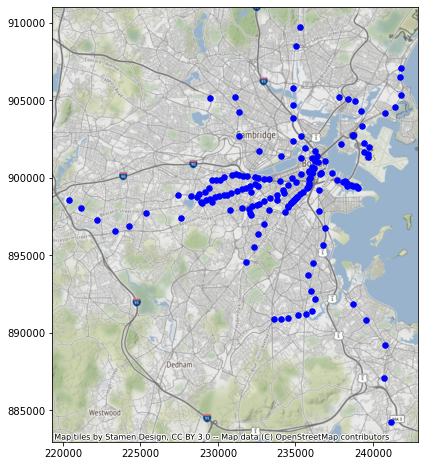

In [495]:
#plotting t points within Boston zip codes
import contextily as cx
fig, ax = plt.subplots(figsize=(10,8))

#need to add title and make map size larger
tpoints.plot(ax=ax, color='blue', markersize=30);

#zcta_boston.plot(ax=ax, facecolor='gray');

cx.add_basemap(ax, crs=tpoints.crs.to_string()) #crs to string outputs coordinates of tpoints dataset

Clearly, T stops are fewer and further between than bus stops. Now we'll join T stop data with zip code data to see which zip codes have the densest concentration of these key transit access points.

In [496]:
#Join to facilitate summarizing indicator values of T points for each ZCTA in the study area
joined_ts = gpd.sjoin(tpoints, zcta_boston, how='left', op='intersects') 
#Group by number of stations per zip code
ts_perzip = joined_ts.groupby('ZCTA5CE10')[['STATION']].nunique().reset_index() #double square brackets for df
#ts_perzip.sort_values(by='nunique',ascending=False)
ts_perzip.rename(columns={'STATION':'station_count'},inplace=True)
#need to join back to zip codes df
zcta_boston = zcta_boston.merge(ts_perzip, how='left', on='ZCTA5CE10')
#in station_count replace NaNs with 0
zcta_boston['station_count'] = zcta_boston['station_count'].fillna(0)
#take a look at new df to be used for visuals
zcta_boston

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry,stop_count,bus_density,bus_norm,station_count
0,25,1905,2501905,B5,G6350,S,9219345,1195154,+42.4659985,-070.9757922,N,"POLYGON ((243830.175 913871.662, 243877.753 91...",122.0,0.000013,0.354279,0.0
1,25,1904,2501904,B5,G6350,S,11708211,1303900,+42.4924563,-070.9739297,N,"POLYGON ((245713.029 914796.777, 245700.484 91...",132.0,0.000011,0.301835,0.0
2,25,1915,2501915,B5,G6350,S,39091336,3958118,+42.5702688,-070.8669962,N,"POLYGON ((250741.171 926889.812, 250787.714 92...",80.0,0.000002,0.054789,0.0
3,25,2462,2502462,B5,G6350,S,1369318,69749,+42.3287076,-071.2559002,N,"MULTIPOLYGON (((222090.890 897305.465, 222058....",0.0,0.000000,0.000000,1.0
4,25,1760,2501760,B5,G6350,S,38359306,2599042,+42.2848223,-071.3488109,N,"POLYGON ((208151.539 893024.178, 208131.535 89...",0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,25,2071,2502071,B5,G6350,S,2513156,33452,+42.1034247,-071.2735885,N,"MULTIPOLYGON (((217320.943 872620.799, 217310....",0.0,0.000000,0.000000,0.0
157,25,2343,2502343,B5,G6350,S,18146751,280250,+42.1489129,-071.0037371,N,"POLYGON ((243087.621 878272.261, 243078.760 87...",56.0,0.000003,0.082618,0.0
158,25,2129,2502129,B5,G6350,S,3492181,1266666,+42.3796570,-071.0614875,N,"POLYGON ((235383.264 902518.035, 235381.204 90...",64.0,0.000018,0.490647,2.0
159,25,2128,2502128,B5,G6350,S,12561059,2952872,+42.3611289,-071.0069754,N,"POLYGON ((237939.099 904138.351, 237949.737 90...",104.0,0.000008,0.221663,10.0


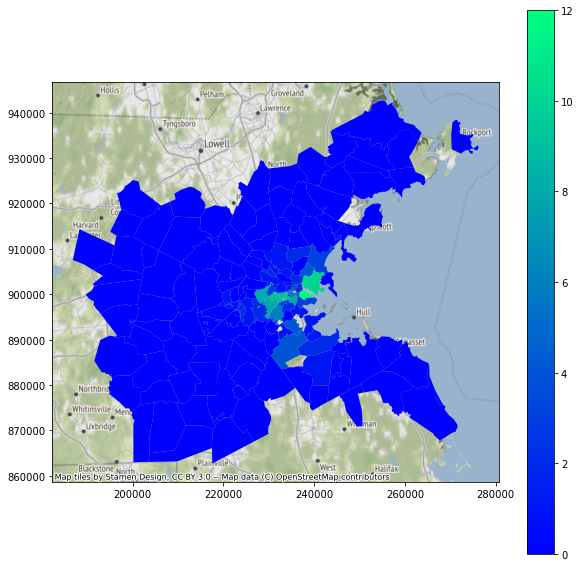

In [511]:
#3)Produce a choropleth map visualizing the indicator values and produce a ZCTA ranking based on the indicator values, reporting the highest and lowest ranking ZCTAs.

#add the contextily basemap, add title

#ranking: number of Ts per zip code
ax = zcta_boston.plot(column='station_count',
           alpha=1,
           legend=True,
           cmap='winter',
           figsize=(10, 10))
cx.add_basemap(ax, crs=tpoints.crs.to_string()) #crs to string outputs coordinates of tpoints dataset

Below we see the 5 zip codes most saturated with T stations, and 5 of the zip codes that do not contain any.

In [498]:
#3 contd. produce a ZCTA ranking based on the indicators
zcta_sorted = zcta_boston.sort_values(by=['station_count'], ascending=False)
zcta_sorted

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry,stop_count,bus_density,bus_norm,station_count
120,25,2210,2502210,B5,G6350,S,2399614,1404157,+42.3477923,-071.0395624,N,"POLYGON ((236840.995 900200.325, 236796.115 90...",41.0,1.708608e-05,0.457434,12.0
159,25,2128,2502128,B5,G6350,S,12561059,2952872,+42.3611289,-071.0069754,N,"POLYGON ((237939.099 904138.351, 237949.737 90...",104.0,8.279557e-06,0.221663,10.0
84,25,2446,2502446,B5,G6350,S,3333660,11957,+42.3435034,-071.1222479,N,"POLYGON ((230796.803 900058.050, 230823.582 90...",22.0,6.599353e-06,0.176680,9.0
155,25,2215,2502215,B5,G6350,S,1979040,280050,+42.3475927,-071.1029340,N,"POLYGON ((230893.478 900182.882, 230882.811 90...",48.0,2.425418e-05,0.649341,9.0
55,25,2115,2502115,B5,G6350,S,1834246,103612,+42.3363418,-071.1041760,N,"POLYGON ((233791.347 900201.106, 233785.591 90...",49.0,2.671397e-05,0.715195,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,25,2163,2502163,B5,G6350,S,256727,32165,+42.3661684,-071.1228503,N,"POLYGON ((230919.432 901942.469, 230987.287 90...",0.0,0.000000e+00,0.000000,0.0
53,25,2121,2502121,B5,G6350,S,4520355,23476,+42.3062667,-071.0858974,N,"POLYGON ((233437.788 896011.798, 233455.909 89...",95.0,2.101605e-05,0.562649,0.0
51,25,2113,2502113,B5,G6350,S,260829,0,+42.3653348,-071.0552357,N,"POLYGON ((236709.574 901967.559, 236727.610 90...",1.0,3.833930e-06,0.102643,0.0
50,25,2021,2502021,B5,G6350,S,48682844,2114286,+42.1757371,-071.1253849,N,"POLYGON ((230413.368 886376.020, 230415.894 88...",25.0,5.135279e-07,0.013748,0.0


In order to develop a suitability indicator based on this data, we next normalize the indicator values into a suitability index ranging from 0 to 1. Locations with the most train stations should be at the highest end of this scale. Below is the new data frame with a column added for normalized values.

In [499]:
#Normalize the indicator values into a suitability or vulnerability index ranging from zero to one.

zcta_boston['stations_norm'] = (zcta_boston['station_count']-zcta_boston['station_count'].min())/(zcta_boston['station_count'].max()-zcta_boston['station_count'].min())
zcta_boston

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry,stop_count,bus_density,bus_norm,station_count,stations_norm
0,25,1905,2501905,B5,G6350,S,9219345,1195154,+42.4659985,-070.9757922,N,"POLYGON ((243830.175 913871.662, 243877.753 91...",122.0,0.000013,0.354279,0.0,0.000000
1,25,1904,2501904,B5,G6350,S,11708211,1303900,+42.4924563,-070.9739297,N,"POLYGON ((245713.029 914796.777, 245700.484 91...",132.0,0.000011,0.301835,0.0,0.000000
2,25,1915,2501915,B5,G6350,S,39091336,3958118,+42.5702688,-070.8669962,N,"POLYGON ((250741.171 926889.812, 250787.714 92...",80.0,0.000002,0.054789,0.0,0.000000
3,25,2462,2502462,B5,G6350,S,1369318,69749,+42.3287076,-071.2559002,N,"MULTIPOLYGON (((222090.890 897305.465, 222058....",0.0,0.000000,0.000000,1.0,0.083333
4,25,1760,2501760,B5,G6350,S,38359306,2599042,+42.2848223,-071.3488109,N,"POLYGON ((208151.539 893024.178, 208131.535 89...",0.0,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,25,2071,2502071,B5,G6350,S,2513156,33452,+42.1034247,-071.2735885,N,"MULTIPOLYGON (((217320.943 872620.799, 217310....",0.0,0.000000,0.000000,0.0,0.000000
157,25,2343,2502343,B5,G6350,S,18146751,280250,+42.1489129,-071.0037371,N,"POLYGON ((243087.621 878272.261, 243078.760 87...",56.0,0.000003,0.082618,0.0,0.000000
158,25,2129,2502129,B5,G6350,S,3492181,1266666,+42.3796570,-071.0614875,N,"POLYGON ((235383.264 902518.035, 235381.204 90...",64.0,0.000018,0.490647,2.0,0.166667
159,25,2128,2502128,B5,G6350,S,12561059,2952872,+42.3611289,-071.0069754,N,"POLYGON ((237939.099 904138.351, 237949.737 90...",104.0,0.000008,0.221663,10.0,0.833333


#### Points of Interest | Fresh Food Access (the farmer's market!)

In [466]:
#read in farmers markets
markets = gpd.read_file("\\Users\\finas\\Documents\\my work\\School work\\Tufts GRAD\\Spring 2021\\UEP239\\uep239-final-project\\project_data\\FARMERSMARKETS_PT\\FARMERSMARKETS_PT.shp")
#set crs
markets = markets.to_crs("EPSG:6491")
markets.crs
#plotting markets 
markets_clipped = gpd.clip(markets, zcta_boston)

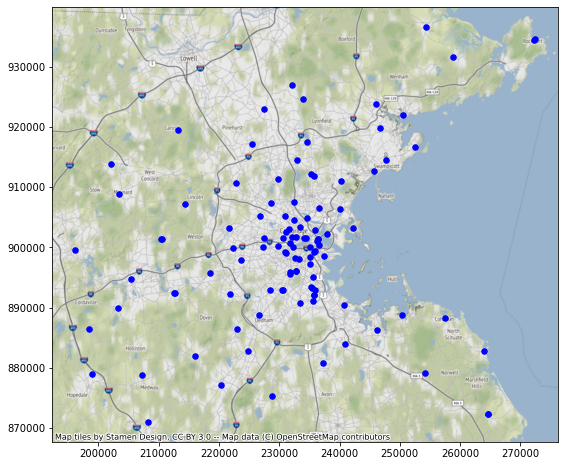

In [467]:
#plotting t points within Boston zip codes
import contextily as cx
fig, ax = plt.subplots(figsize=(10,8))

#need to add title and make map size larger
markets_clipped.plot(ax=ax, color='blue', markersize=30);
cx.add_basemap(ax, crs=markets_clipped.crs.to_string()) #crs to string outputs coordinates of tpoints dataset

## Demographic Indicators
#### Now we'll shift our analysis from points of interest to populations of interest. We will use ACS census data to look first at areas with optimal age ranges (the twenties), then will examine rent medians.

First we will read in tabular American Community Survey census data to look at our variables "S0101_C02_006E" and "S0101_C02_007E" which represent the estimated percent of total zip code population aged 20-24 and 25-29, respectively. (We will fix those variable names in a second.) Personally, I'd prefer to live around other people in their twenties, but beyond that I'm unconcerned what age my neighbors are, meaning we will not include any other age ranges beyond the twenties as weights in our index.

In [442]:
#indicator for age and sex, csv format
age_table= pd.read_csv("\\Users\\finas\\Documents\\my work\\School work\\Tufts GRAD\\Spring 2021\\UEP239\\uep239-final-project\\project_data\\ACS_Age_Sex_Data\\ACSST5Y2019.S0101_data_with_overlays.csv",skiprows=[1])
#subset by variables of interest
age_subset= age_table[['NAME','S0101_C02_006E','S0101_C02_007E']]
#check for nulls
age_subset.isnull().sum()

NAME              0
S0101_C02_006E    0
S0101_C02_007E    0
dtype: int64

We need to do a little bit of cleanup before we can merge this into our zip codes gdf.

In [392]:
#remove extra letters from first part of string so the columns will match
age_subset['ZCTA5CE10'] = age_subset['NAME'].apply(lambda x:int(x[5:]))

In [393]:
#I also will need both zip code columns to be type numeric
zctas_clipped['ZCTA5CE10']=pd.to_numeric(zctas_clipped['ZCTA5CE10'])
age_subset['NAME']=pd.to_numeric(zctas_clipped['ZCTA5CE10'])

In [402]:
#join table to original zctas df that is the same shape
agedf = zctas_clipped.merge(age_subset, how='left', on='ZCTA5CE10') 

<AxesSubplot:>

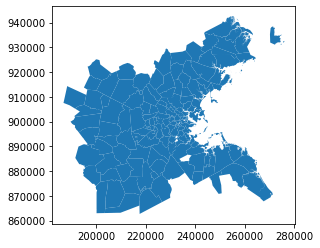

In [404]:
#clip to Boston again & plot for sanity check
zcta_bos2 = agedf[agedf.centroid.within(mpo['geometry'][10])]
zcta_bos2.plot()

In [414]:
#Now we can rename our columns to make it clear that they represent age medians and take a look at our table. We're also going to need these to be numeric types.
zcta_bos2 = zcta_bos2.rename(columns={'S0101_C02_006E':'med20_24', 'S0101_C02_007E':'med25_29'})
zcta_bos2['med20_24']=pd.to_numeric(zcta_bos2['med20_24'])
zcta_bos2['med25_29']=pd.to_numeric(zcta_bos2['med25_29'])
zcta_bos2

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry,NAME,med20_24,med25_29,twenties
17,25,1905,2501905,B5,G6350,S,9219345,1195154,+42.4659985,-070.9757922,N,"MULTIPOLYGON (((243877.753 913824.638, 243872....",1844.0,6.4,7.5,6.47.5
18,25,1904,2501904,B5,G6350,S,11708211,1303900,+42.4924563,-070.9739297,N,"POLYGON ((245700.484 914778.700, 245667.412 91...",1833.0,7.0,7.4,7.07.4
21,25,1915,2501915,B5,G6350,S,39091336,3958118,+42.5702688,-070.8669962,N,"MULTIPOLYGON (((250787.714 926889.372, 251155....",1364.0,9.2,6.4,9.26.4
35,25,2462,2502462,B5,G6350,S,1369318,69749,+42.3287076,-071.2559002,N,"MULTIPOLYGON (((222058.060 897313.471, 222020....",2760.0,4.2,3.7,4.23.7
37,25,1760,2501760,B5,G6350,S,38359306,2599042,+42.2848223,-071.3488109,N,"POLYGON ((208131.535 893134.452, 208128.879 89...",2564.0,3.6,5.8,3.65.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,25,2343,2502343,B5,G6350,S,18146751,280250,+42.1489129,-071.0037371,N,"POLYGON ((243078.760 878153.357, 243068.844 87...",1588.0,4.4,2.8,4.42.8
526,25,2129,2502129,B5,G6350,S,3492181,1266666,+42.3796570,-071.0614875,N,"MULTIPOLYGON (((235381.204 902518.358, 235374....",1370.0,3.3,11.0,3.311.0
527,25,2128,2502128,B5,G6350,S,12561059,2952872,+42.3611289,-071.0069754,N,"MULTIPOLYGON (((240204.477 905138.116, 240343....",1054.0,6.5,11.8,6.511.8
528,25,2122,2502122,B5,G6350,S,5263269,1641767,+42.2914125,-071.0421575,N,"MULTIPOLYGON (((237311.389 892366.860, 237300....",1970.0,6.5,12.6,6.512.6


As I am primarily concerned about living near other people in their twenties, I will join these fields to get a category that represents total percent of every zip code population in their twenties. The below data table contains "twenties" as an indicator summarized by ZCTA.

In [415]:
#I am most concerned about living with other people in their twenties, so I will perform a field calculation to get a total percent value that we will use as our indicator.
zcta_bos2['twenties']=zcta_bos2['med20_24']+zcta_bos2['med25_29']
zcta_bos2

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry,NAME,med20_24,med25_29,twenties
17,25,1905,2501905,B5,G6350,S,9219345,1195154,+42.4659985,-070.9757922,N,"MULTIPOLYGON (((243877.753 913824.638, 243872....",1844.0,6.4,7.5,13.9
18,25,1904,2501904,B5,G6350,S,11708211,1303900,+42.4924563,-070.9739297,N,"POLYGON ((245700.484 914778.700, 245667.412 91...",1833.0,7.0,7.4,14.4
21,25,1915,2501915,B5,G6350,S,39091336,3958118,+42.5702688,-070.8669962,N,"MULTIPOLYGON (((250787.714 926889.372, 251155....",1364.0,9.2,6.4,15.6
35,25,2462,2502462,B5,G6350,S,1369318,69749,+42.3287076,-071.2559002,N,"MULTIPOLYGON (((222058.060 897313.471, 222020....",2760.0,4.2,3.7,7.9
37,25,1760,2501760,B5,G6350,S,38359306,2599042,+42.2848223,-071.3488109,N,"POLYGON ((208131.535 893134.452, 208128.879 89...",2564.0,3.6,5.8,9.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,25,2343,2502343,B5,G6350,S,18146751,280250,+42.1489129,-071.0037371,N,"POLYGON ((243078.760 878153.357, 243068.844 87...",1588.0,4.4,2.8,7.2
526,25,2129,2502129,B5,G6350,S,3492181,1266666,+42.3796570,-071.0614875,N,"MULTIPOLYGON (((235381.204 902518.358, 235374....",1370.0,3.3,11.0,14.3
527,25,2128,2502128,B5,G6350,S,12561059,2952872,+42.3611289,-071.0069754,N,"MULTIPOLYGON (((240204.477 905138.116, 240343....",1054.0,6.5,11.8,18.3
528,25,2122,2502122,B5,G6350,S,5263269,1641767,+42.2914125,-071.0421575,N,"MULTIPOLYGON (((237311.389 892366.860, 237300....",1970.0,6.5,12.6,19.1


#### Visualizing and sorting out Boston's "twenties" 
Below we will reveal where people tend to live in Boston if they're in their twenties.

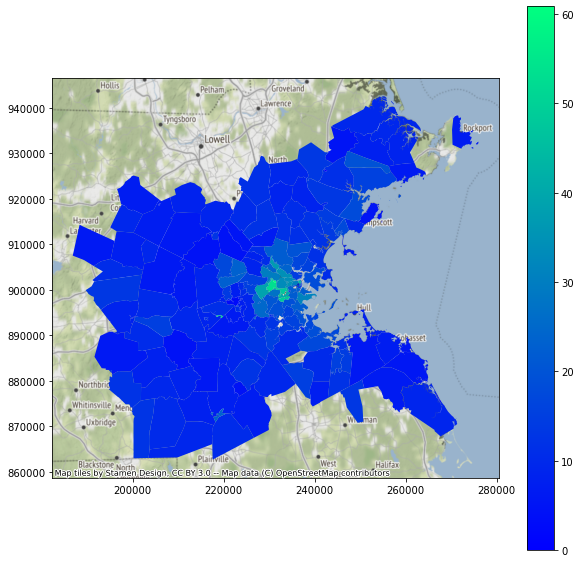

In [512]:
ax = zcta_bos2.plot(column='twenties',
           alpha=1,
           #ax=base,
           legend=True,
           cmap='winter',
           figsize=(10, 10))

cx.add_basemap(ax, crs=zcta_bos2.crs.to_string()) #crs to string outputs coordinates of tpoints dataset

Wow- this map and legend make it look like there could be neighborhoods in Boston where 60% of people are in their twenties, along with a significant amount that look to be housing a near-zero percentage of twentysomethings. Let's look at a table of values sorted by percent of total zip population aged 20-29 to learn more.

In [420]:
zcta_twenties = zcta_bos2.sort_values(by=['twenties'], ascending=False)
zcta_twenties

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry,NAME,med20_24,med25_29,twenties
187,25,2163,2502163,B5,G6350,S,256727,32165,+42.3661684,-071.1228503,N,"POLYGON ((230987.287 902040.072, 230992.359 90...",2453.0,15.2,45.7,60.9
50,25,2134,2502134,B5,G6350,S,3435273,117848,+42.3580164,-071.1286084,N,"POLYGON ((231551.091 901254.927, 231552.405 90...",1521.0,23.3,29.7,53.0
114,25,2457,2502457,B5,G6350,S,413241,0,+42.2993878,-071.2742420,N,"POLYGON ((219395.018 894055.646, 219398.270 89...",1255.0,49.5,0.5,50.0
470,25,2120,2502120,B5,G6350,S,1607730,0,+42.3320907,-071.0965454,N,"POLYGON ((234183.518 898695.900, 234224.874 89...",1835.0,32.4,15.6,48.0
522,25,2215,2502215,B5,G6350,S,1979040,280050,+42.3475927,-071.1029340,N,"POLYGON ((230882.811 900191.721, 230910.865 90...",2056.0,33.4,14.1,47.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,25,2421,2502421,B5,G6350,S,25510908,417186,+42.4385472,-071.2395735,N,"POLYGON ((219153.179 909306.903, 219130.387 90...",2561.0,2.7,1.6,4.3
162,25,2468,2502468,B5,G6350,S,3833292,57129,+42.3285534,-071.2295534,N,"POLYGON ((223199.611 898594.527, 223210.251 89...",1944.0,2.2,0.4,2.6
344,25,1937,2501937,B5,G6350,S,189212,0,+42.5857233,-070.9840508,N,"POLYGON ((242709.087 926235.788, 242723.270 92...",1098.0,0.0,0.0,0.0
244,25,2047,2502047,B5,G6350,S,619346,21837,+42.1337338,-070.6858599,N,"POLYGON ((267395.076 875836.101, 267422.154 87...",2379.0,0.0,0.0,0.0


From the lowest values at the bottom of this table, we've also learned that there are multiple zip codes in Boston where 0% of people are in their twenties! Some quick research shows that this includes the zip code "02047", a small coastal zip code with a total 2019 population of 97 people, as well as the 02203 zip code that covers just a few blocks near downtown's Government Center T stop. It seems that these results are plausible and we can proceed with our analysis. 

#### Scaling to create our third suitability index value 

In [424]:
#normalizing, then checking against the sorted table to make sure the calculations line up
zcta_bos2['twentynorm'] = (zcta_bos2['twenties']-zcta_bos2['twenties'].min())/(zcta_bos2['twenties'].max()-zcta_bos2['twenties'].min())
zcta_bos2.sort_values(by=['twenties'], ascending=False)

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry,NAME,med20_24,med25_29,twenties,twentynorm
187,25,2163,2502163,B5,G6350,S,256727,32165,+42.3661684,-071.1228503,N,"POLYGON ((230987.287 902040.072, 230992.359 90...",2453.0,15.2,45.7,60.9,1.000000
50,25,2134,2502134,B5,G6350,S,3435273,117848,+42.3580164,-071.1286084,N,"POLYGON ((231551.091 901254.927, 231552.405 90...",1521.0,23.3,29.7,53.0,0.870279
114,25,2457,2502457,B5,G6350,S,413241,0,+42.2993878,-071.2742420,N,"POLYGON ((219395.018 894055.646, 219398.270 89...",1255.0,49.5,0.5,50.0,0.821018
470,25,2120,2502120,B5,G6350,S,1607730,0,+42.3320907,-071.0965454,N,"POLYGON ((234183.518 898695.900, 234224.874 89...",1835.0,32.4,15.6,48.0,0.788177
522,25,2215,2502215,B5,G6350,S,1979040,280050,+42.3475927,-071.1029340,N,"POLYGON ((230882.811 900191.721, 230910.865 90...",2056.0,33.4,14.1,47.5,0.779967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,25,2421,2502421,B5,G6350,S,25510908,417186,+42.4385472,-071.2395735,N,"POLYGON ((219153.179 909306.903, 219130.387 90...",2561.0,2.7,1.6,4.3,0.070608
162,25,2468,2502468,B5,G6350,S,3833292,57129,+42.3285534,-071.2295534,N,"POLYGON ((223199.611 898594.527, 223210.251 89...",1944.0,2.2,0.4,2.6,0.042693
344,25,1937,2501937,B5,G6350,S,189212,0,+42.5857233,-070.9840508,N,"POLYGON ((242709.087 926235.788, 242723.270 92...",1098.0,0.0,0.0,0.0,0.000000
244,25,2047,2502047,B5,G6350,S,619346,21837,+42.1337338,-070.6858599,N,"POLYGON ((267395.076 875836.101, 267422.154 87...",2379.0,0.0,0.0,0.0,0.000000


Now we have created our third index, which is scaled from 0 to 1 where 1 means most suitable and highest percent of residents in their twenties. 

#### Index 4: Boston Rent Medians

Now we'll use Census Bureau Population Estimates data on financial characteristics to see where in Boston montly housing costs are highest. We'll do this by extracting a variable that represents monthly median housing costs, titled "S2503_C01_024E."

In [472]:
financial = pd.read_csv("\\Users\\finas\\Documents\\my work\\School work\\Tufts GRAD\\Spring 2021\\UEP239\\uep239-final-project\\project_data\\ACS_Financial_Characteristics\\ACSST5Y2019.S2503_data_with_overlays.csv",skiprows=[1])
#subset by variables of interest, median income and what we'll need to join
fin_subset= financial[['NAME','S2503_C01_024E']] 
fin_subset

,NAME,S2503_C01_024E
0,ZCTA5 01001,1141
1,ZCTA5 01002,1405
2,ZCTA5 01003,1219
3,ZCTA5 01005,1127
4,ZCTA5 01007,1368
...,...,...
532,ZCTA5 02777,1515
533,ZCTA5 02779,1582
534,ZCTA5 02780,1218
535,ZCTA5 02790,1300


In [473]:
#remove extra letters from first part of string so the columns will match
fin_subset['ZCTA5CE10'] = fin_subset['NAME'].apply(lambda x:int(x[5:]))
#similar merge prepping to that performed on the last ACS table: converting columns to numeric
fin_subset['ZCTA5CE10']=pd.to_numeric(fin_subset['ZCTA5CE10'])
fin_subset['NAME']=pd.to_numeric(fin_subset['ZCTA5CE10'])
#join table to original zctas df that is the same shape
rentdf = zctas_clipped.merge(fin_subset, how='left', on='ZCTA5CE10') 
rentdf

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry,NAME,S2503_C01_024E
0,25,2536,2502536,B5,G6350,S,71696166,9066635,+41.5969756,-070.5678768,N,"MULTIPOLYGON (((275688.314 812598.785, 275674....",2536.0,1411
1,25,2556,2502556,B5,G6350,S,10034104,1164445,+41.6394454,-070.6245149,N,"MULTIPOLYGON (((272816.173 818906.998, 272692....",2556.0,1429
2,25,2540,2502540,B5,G6350,S,27746696,4550024,+41.5741900,-070.6282848,N,"MULTIPOLYGON (((273126.263 818856.200, 273125....",2540.0,1196
3,25,2646,2502646,B5,G6350,S,7798581,801405,+41.6705961,-070.0714493,N,"MULTIPOLYGON (((318348.040 826281.410, 318355....",2646.0,1366
4,25,1237,2501237,B5,G6350,S,160121626,1140685,+42.5478177,-073.2680327,N,"POLYGON ((57310.861 917322.668, 57280.413 9173...",1237.0,1217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,25,1537,2501537,B5,G6350,S,18085937,295745,+42.1589660,-071.8970514,N,"POLYGON ((167131.394 882124.787, 167132.834 88...",1537.0,1117
534,25,1503,2501503,B5,G6350,S,33598202,523984,+42.3849290,-071.6338895,N,"POLYGON ((192620.359 903410.285, 192571.893 90...",1503.0,1610
535,25,1452,2501452,B5,G6350,S,106373488,2406515,+42.4895983,-072.0028783,N,"POLYGON ((155270.303 910753.057, 155048.771 91...",1452.0,1327
536,25,1571,2501571,B5,G6350,S,53915863,2717076,+42.0537777,-071.9350751,N,"POLYGON ((162378.916 864062.624, 162368.069 86...",1571.0,1165


In [477]:
#clip to Boston again
zcta_bos3 = rentdf[rentdf.centroid.within(mpo['geometry'][10])]

In [478]:
#Now we can rename our column to make it clear that it's representing rent medians and take a look at it. 
zcta_bos3 = zcta_bos3.rename(columns={'S2503_C01_024E':'median_rent'})
#This column wasn't easily converted to numeric type so we check for nulls... hmmm.
zcta_bos3['median_rent'].isnull().sum()

0

In [479]:
#We suspect there are still missing values, but don't want to replace these with 0 since they will bring down our stats. We temporarily fill them with NaNs.
zcta_bos3['median_rent'] = pd.to_numeric(zcta_bos3['median_rent'], errors='coerce')
#Instead we want to fill them with averages.
zcta_bos3['median_rent'] = zcta_bos3['median_rent'].fillna(value=zcta_bos3['median_rent'].mean())

In [481]:
zcta_bos3['median_rent'].mean()

2074.6770186335402

#### Visualizing Boston's Rent Medians

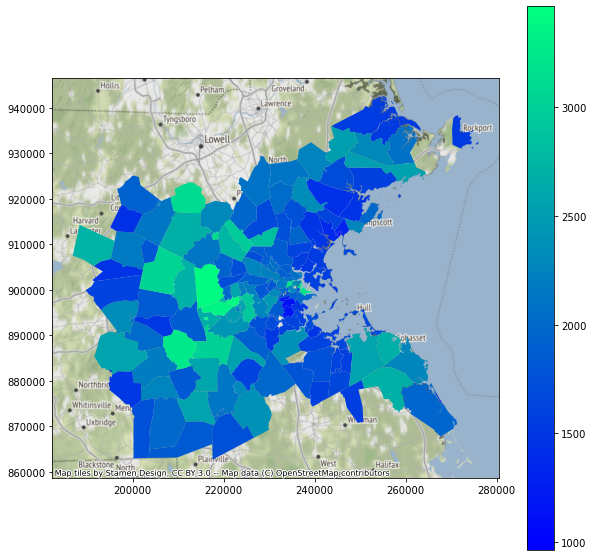

In [508]:
ax = zcta_bos3.plot(column='median_rent',
           alpha=1,
           #ax=base,
           legend=True,
           cmap='winter',
           figsize=(10, 10))

cx.add_basemap(ax, crs=zcta_bos3.crs) 

In [484]:
zcta_rents = zcta_bos3.sort_values(by=['median_rent'], ascending=False)
zcta_rents

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry,NAME,median_rent
162,25,2468,2502468,B5,G6350,S,3833292,57129,+42.3285534,-071.2295534,N,"POLYGON ((223199.611 898594.527, 223210.251 89...",2468.0,3465.0
300,25,2493,2502493,B5,G6350,S,43574801,1316917,+42.3605016,-071.3034335,N,"POLYGON ((219855.053 898442.328, 219856.802 89...",2493.0,3408.0
236,25,2481,2502481,B5,G6350,S,14612716,246885,+42.3119273,-071.2755312,N,"MULTIPOLYGON (((216252.776 893530.072, 216227....",2481.0,3350.0
455,25,1770,2501770,B5,G6350,S,40966896,961380,+42.2335699,-071.3746897,N,"POLYGON ((209232.202 883767.584, 209231.358 88...",1770.0,3246.0
52,25,2110,2502110,B5,G6350,S,479769,234496,+42.3619623,-071.0478465,N,"POLYGON ((236616.078 900814.523, 236644.730 90...",2110.0,3216.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,25,2120,2502120,B5,G6350,S,1607730,0,+42.3320907,-071.0965454,N,"POLYGON ((234183.518 898695.900, 234224.874 89...",2120.0,1203.0
184,25,2121,2502121,B5,G6350,S,4520355,23476,+42.3062667,-071.0858974,N,"POLYGON ((233455.909 896032.433, 233462.956 89...",2121.0,1184.0
185,25,2119,2502119,B5,G6350,S,4136145,0,+42.3240256,-071.0850214,N,"POLYGON ((235115.975 898168.657, 235148.036 89...",2119.0,1121.0
244,25,2047,2502047,B5,G6350,S,619346,21837,+42.1337338,-070.6858599,N,"POLYGON ((267395.076 875836.101, 267422.154 87...",2047.0,983.0


#### We're normalizing this again but reversing the scale so that a low median rent is highly ranked!

In [491]:
#switching min and max in the normalization formula, then checking to make sure the rent_norm values align with the median_rent column in a way that makes sense
zcta_rents['rent_norm'] = (zcta_rents['median_rent']-zcta_rents['median_rent'].max())/(zcta_rents['median_rent'].min()-zcta_rents['median_rent'].max())
zcta_rents.sort_values(by=['rent_norm'], ascending=False)

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry,NAME,median_rent,rent_norm
150,25,1901,2501901,B5,G6350,S,641320,68753,+42.4607111,-070.9460730,N,"MULTIPOLYGON (((245437.876 912898.595, 245475....",1901.0,964.0,1.000000
244,25,2047,2502047,B5,G6350,S,619346,21837,+42.1337338,-070.6858599,N,"POLYGON ((267395.076 875836.101, 267422.154 87...",2047.0,983.0,0.992403
185,25,2119,2502119,B5,G6350,S,4136145,0,+42.3240256,-071.0850214,N,"POLYGON ((235115.975 898168.657, 235148.036 89...",2119.0,1121.0,0.937225
184,25,2121,2502121,B5,G6350,S,4520355,23476,+42.3062667,-071.0858974,N,"POLYGON ((233455.909 896032.433, 233462.956 89...",2121.0,1184.0,0.912035
470,25,2120,2502120,B5,G6350,S,1607730,0,+42.3320907,-071.0965454,N,"POLYGON ((234183.518 898695.900, 234224.874 89...",2120.0,1203.0,0.904438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,25,2110,2502110,B5,G6350,S,479769,234496,+42.3619623,-071.0478465,N,"POLYGON ((236616.078 900814.523, 236644.730 90...",2110.0,3216.0,0.099560
455,25,1770,2501770,B5,G6350,S,40966896,961380,+42.2335699,-071.3746897,N,"POLYGON ((209232.202 883767.584, 209231.358 88...",1770.0,3246.0,0.087565
236,25,2481,2502481,B5,G6350,S,14612716,246885,+42.3119273,-071.2755312,N,"MULTIPOLYGON (((216252.776 893530.072, 216227....",2481.0,3350.0,0.045982
300,25,2493,2502493,B5,G6350,S,43574801,1316917,+42.3605016,-071.3034335,N,"POLYGON ((219855.053 898442.328, 219856.802 89...",2493.0,3408.0,0.022791


## Final Suitability Calculations
#### Now that we've created an index for each of our variables of interest, it's time to add up our scale. This will give us our suitability ranking of 5 which we can use to evaluate a neighborhood to settle in. Here's how we can calculate an unweighted index based on the indicators we've established thus far:

In [510]:
#unweighted index
zcta_boston['indicatorsum'] = zcta_rents['rent_norm']+zcta_bos2['twentynorm']+zcta_boston['stations_norm']+zcta_boston['bus_norm']

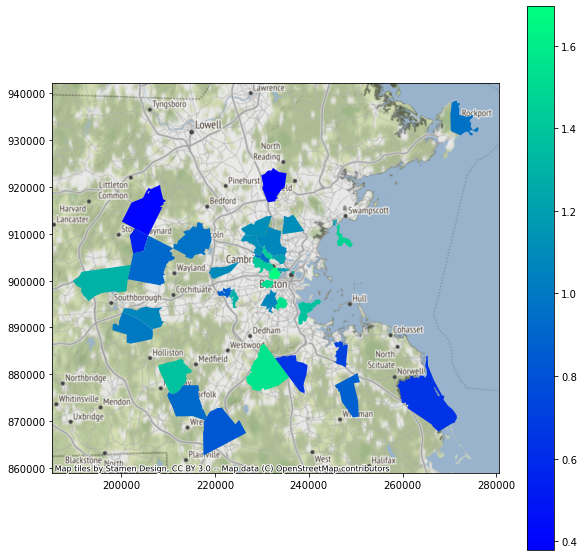

In [509]:
ax = zcta_boston.plot(column='indicatorsum',
           alpha=1,
           legend=True,
           cmap='winter',
           figsize=(10, 10))

cx.add_basemap(ax, crs=zcta_boston.crs) 

Because of how we assigned values of 0 to a lot of our data, it seems many zip codes have now vanished from our prospects. This will help us narrow down the choice. However, we could make an even more refined choice by weighting the data.

//Summarize the indicator values (like population density) for each ZCTA in the study area.//


#Convert the indicator values into a suitability or vulnerability index or score. This can be done in two ways:


#Reclassify the indicator values based on classes of your choice into a five-point (or ten-point) score.

Summarize the single indicator based scores or indices into an overall weighted or unweighted score or index. You should justify any chosen weights or the decision to forego weighting the indicators (assigning each indicator an equal weight). You are welcome to produce both a weighted and an unweighted overall index or score.

In [435]:
zcta_bos3.dtypes

STATEFP10        object
ZCTA5CE10         int64
GEOID10          object
CLASSFP10        object
MTFCC10          object
FUNCSTAT10       object
ALAND10           int64
AWATER10          int64
INTPTLAT10       object
INTPTLON10       object
PARTFLG10        object
geometry       geometry
NAME            float64
median_rent      object
dtype: object


Visualize the overall suitability or vulnerability index or score on a choropleth map and produce a ZCTA ranking based on the score or index, reporting the highest and lowest ranking ZCTAs.

Unweighted index results:

Weighted index results: